# This notebook was originally made by Jesse Hoogland (based on code by Marius Hobbhahn and Neel Nanda), and then modified for the DOTS use case with permission from Jesse
(some of the code from here also moved into models.py and modified to be appropriate for this use case)

In [2]:
!nvidia-smi

Wed May 24 16:10:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:C1:00.0 Off |                    0 |
| N/A   35C    P0    75W / 500W |  52719MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set-up

## Imports

In [17]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import random
import time
from pathlib import Path
import pickle
import os
import copy
from collections import OrderedDict
import functools
import itertools
import gc

import numpy as np
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd

from dots.utils import *
from dots.models import *

# pio.renderers.default = "colab"
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyperparameters

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [5]:
lr=1e-3 #@param
weight_decay = 0.1 #@param 
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.3 #@param
NUM_EPOCHS = 100000 #@param
save_models = False #@param
save_every = 1000 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param
seed = 0 #@param
num_layers = 1
batch_style = 'full'
d_vocab = p+1 
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
#batch_size = BATCH_SIZE

In [6]:
def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch  
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

In [7]:
## set torch seed 
SEED = 0
torch.manual_seed(SEED)

# Data

As described in Neel's post, every input sequence is of the form `(i, j, num)` where the target is `i+j mod num`

In [8]:
def gen_train_test(frac_train = 0.3, num = 113, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train_x, test_x = gen_train_test(frac_train, 113, seed=0)
print(len(train_x), len(test_x))

print(train_x[:10])
print(test_x[:10])

3830 8939
[(18, 34, 113), (10, 83, 113), (55, 28, 113), (25, 51, 113), (63, 65, 113), (14, 104, 113), (27, 56, 113), (35, 77, 113), (41, 72, 113), (17, 111, 113)]
[(50, 67, 113), (92, 107, 113), (29, 14, 113), (76, 53, 113), (78, 80, 113), (77, 58, 113), (97, 1, 113), (39, 59, 113), (95, 73, 113), (38, 40, 113)]


In [9]:
### create training and test samples in batches

def collate_batch(batch):
    label_list = [(i+j) % num for (i,j,num) in batch]
    label_list = torch.tensor(label_list, dtype=torch.int64)
    input_list = [torch.tensor(x) for x in batch]
    input_list = torch.cat(input_list).view(len(label_list), -1)
    return input_list.to(DEVICE), label_list.to(DEVICE)

# one batch per loader
train_loader = DataLoader(train_x, batch_size=len(train_x), collate_fn=collate_batch)
test_loader = DataLoader(test_x, batch_size=len(test_x), collate_fn=collate_batch)

print(len(train_loader))
for x, y in train_loader:
    print(x[:10])
    print(y[:10])

1
tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]], device='cuda:0')
tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')


In [10]:
def loss_of_final_number(logits, labels):
    # only look at predictions of last numbers
    logits = logits[:,-1]
    # compute individual and summed losses for final number
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels.unsqueeze(1), dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

In [16]:
for x, y in test_loader:
    print(f"x: {x.shape}")

x: torch.Size([8939, 3])


# Training

In [11]:
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, 
                    d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_ln=False).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))

In [13]:
model

Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (attn): Attention()
      (mlp): TransformerMLP()
    )
  )
  (unembed): Unembed()
)

In [12]:
model.count_params()

226816

In [14]:
save_every

1000

In [20]:
calc_rank_on = next(iter(test_loader))[0][:20]

In [21]:
calc_rank_on.shape

torch.Size([20, 3])

In [ ]:
# train
train_losses = []
test_losses = []
train_accs = []
test_accs = []
ranks = []

weights_epochs = {}
grads_epochs = {}

for i in trange(NUM_EPOCHS, desc="Epoch"):
    final_digit_loss = 0
    for j, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        train_loss = loss_of_final_number(out, y)
        sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
        correct = (y == sm_argmax.view(-1)).detach()

        train_loss.backward()
        optimizer.step()

        final_digit_loss += train_loss.item()

    train_losses.append(final_digit_loss)
    train_accs.append(correct.float().mean().item())

    if i % save_every == 0:
        t.save(model, f"grok_{prepend_zeros(5, i)}.pt")
        ranks.append(
            model.jacobian_matrix_rank(calc_rank_on)
        )
        
        print("epoch {}; training loss {};".format(i, final_digit_loss))
        print("training acc {};".format(correct.float().mean()))
        # run a test every N iterations
        for x, y in test_loader:

            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            test_loss = loss_of_final_number(out, y)
            sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
            correct = (y == sm_argmax.view(-1)).detach()

        print("test loss: {}".format(test_loss.item()))
        print("test acc: {}".format(correct.float().mean()))
        test_losses.append(test_loss.item())
        test_accs.append(correct.float().mean().item())

        print("\n")

        # store the weights
        weights_epochs["weights_epoch_{}".format(i)] = copy.deepcopy(model.state_dict())

        # get and store gradients
        gradient_dict = OrderedDict()
        for name, param in model.named_parameters():
            gradient_dict["grad_{}".format(name)] = copy.deepcopy(param.grad)

        grads_epochs["grads_epoch_{}".format(i)] = gradient_dict


Epoch:   0%|          | 0/100000 [00:00<?, ?it/s]

epoch 0; training loss 4.773175904538197;
training acc 0.007832897827029228;
test loss: 4.75079120766905
test acc: 0.007942723110318184


epoch 1000; training loss 5.40251017844247e-07;
training acc 1.0;
test loss: 30.236904912390013
test acc: 0.2056158483028412




In [23]:
ranks

NameError: name 'ranks' is not defined

In [ ]:
## did it learn the training dist?
for x, y in train_loader:
    out = model(x.to(DEVICE))
    sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:10, -1].detach()
    input = x[:10, :]
    print(x.size())
    print("input: ", input)
    label = y[:10]
    print("label: ", label[:10])
    print("argmax prediction: ", sm_argmax)
    print("same: ", label[:10] == sm_argmax)
    break

torch.Size([3830, 3])
input:  tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]], device='cuda:0')
label:  tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')
argmax prediction:  tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')
same:  tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')


In [ ]:
## test stuff

for x, y in test_loader:
    out = model(x.to(DEVICE))
    sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:10, -1].detach()
    input = x[:10, :]
    print(x.size())
    print("input: ", input)
    label = y[:10]
    print("label: ", label[:10])
    print("argmax prediction: ", sm_argmax)
    print("same: ", label[:10] == sm_argmax)
    break

torch.Size([8939, 3])
input:  tensor([[ 50,  67, 113],
        [ 92, 107, 113],
        [ 29,  14, 113],
        [ 76,  53, 113],
        [ 78,  80, 113],
        [ 77,  58, 113],
        [ 97,   1, 113],
        [ 39,  59, 113],
        [ 95,  73, 113],
        [ 38,  40, 113]], device='cuda:0')
label:  tensor([ 4, 86, 43, 16, 45, 22, 98, 98, 55, 78], device='cuda:0')
argmax prediction:  tensor([ 4, 86, 43, 16, 45, 22, 98, 98, 55, 78], device='cuda:0')
same:  tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')


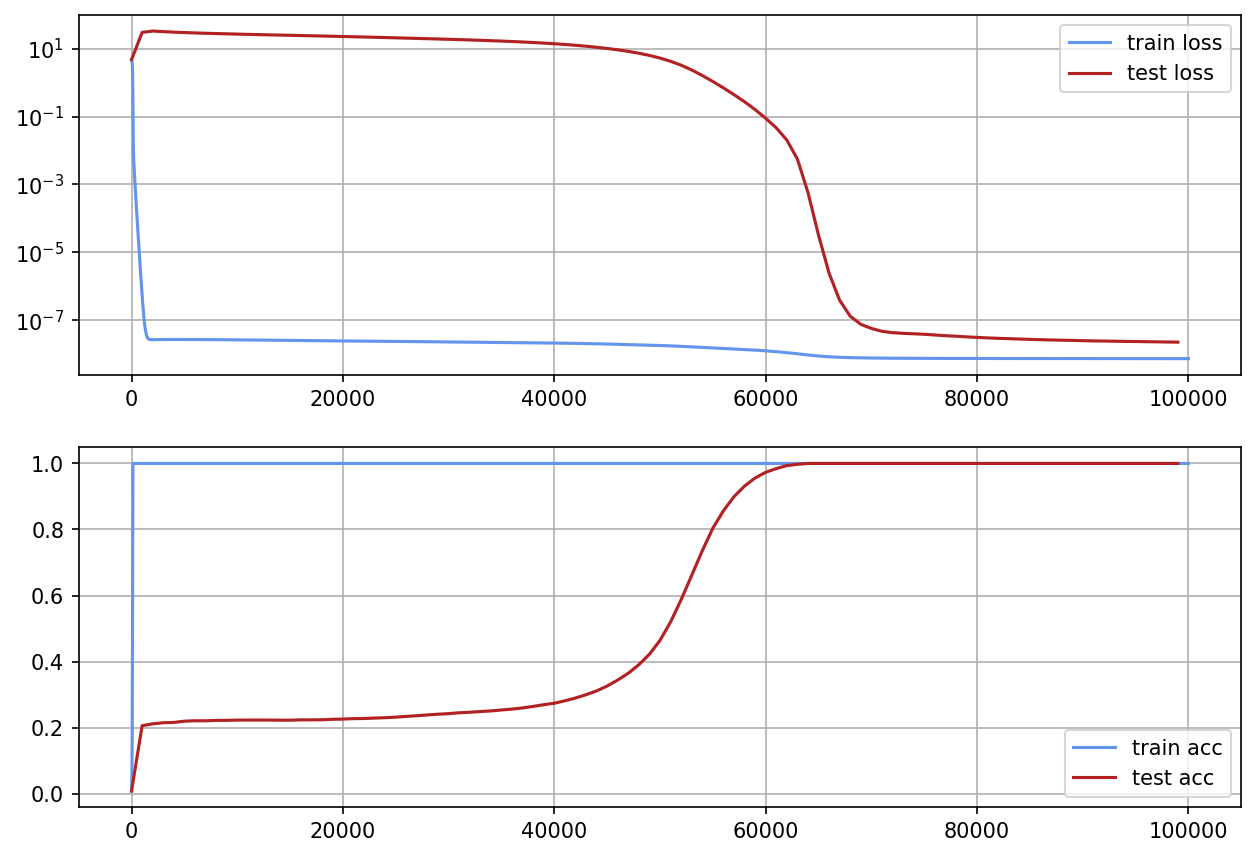

In [ ]:
## plot the training and test loss
x_train = np.arange(len(train_losses)) 
x_test = np.arange(len(test_losses)) * save_every
 
fig, ax = plt.subplots(2,1,figsize=(10, 7), dpi=150)

ax[0].grid()
ax[0].plot(x_train, train_losses, color="cornflowerblue", label="train loss")
ax[0].plot(x_test, test_losses, color="firebrick", label="test loss")
ax[0].legend()
ax[0].set_yscale("log")

ax[1].grid()
ax[1].plot(x_train, train_accs, color="cornflowerblue", label="train acc")
ax[1].plot(x_test, test_accs, color="firebrick", label="test acc")
ax[1].legend()

plt.show()